# The project aims to find distinct group of words in a Wikipedia article

Such solution might be used to automatically group documents, retrieve information about them, create features for search.

In order to measure particular word's importance, Zipf frequency has been used - it provides insight into words' distribution, and ranks it inversely to the number of times it occurs in language corpus. Each word was tokenized, lemmitized, stop words were filtered out.

Array of embeddings for each resulting word have been constructed, based on spaCy build-in embeddings. K-Means clustering (K=10) has been performed, giving us 10 cluster of words.

For each cluster, 10 words closest to its centroid has been printed, first of them was also depicted in 3D graph, giving us a visual insight into words' vector space. In order to transform embedding-size dimension space to 3D space, PCA was used.

In [1]:
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup

import spacy
import string
import re
from wordfreq import zipf_frequency

from sklearn.cluster import KMeans
from sklearn import decomposition

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


respond = requests.get("https://en.wikipedia.org/wiki/Poznań")
soup = BeautifulSoup(respond.text, "lxml")
page = soup.find_all('p')

raw_text = ''.join([paragraph.text for paragraph in page])

print(raw_text)


Poznań (UK: /ˈpɒznæn/, US: /ˈpoʊznæn, ˈpoʊznɑːn/,[2] Polish: [ˈpɔznaɲ] (listen); German: Posen; known also by other historical names) is a city on the Warta River in west-central Poland, in the Greater Poland region and is the fifth-largest city in Poland. It is best known for its renaissance Old Town and Ostrów Tumski Cathedral. Today, Poznań is an important cultural and business centre and one of Poland's most populous regions with many regional customs such as Saint John's Fair (Jarmark Świętojański), traditional Saint Martin's croissants and a local dialect.
Poznań is among the oldest and largest cities in Poland. The city's population is 538,633 (2011 census), while the continuous conurbation with Poznań County and several other communities is inhabited by almost 1.1 million people.[3] The Larger Poznań Metropolitan Area (PMA) is inhabited by 1.3–1.4 million people and extends to such satellite towns as Nowy Tomyśl, Gniezno and Września,[4][5][6][7] making it the fourth largest m

For Wikipedia crawling, BeautifulSoup library has been used. It gives us easy access to common web crawling tasks

Each word that is noun, is not a stopword, its zipf frequency is below a threshold (the lower the frequency, the more significant the word is), was used for clustering

In [2]:
nlp = spacy.load('en_core_web_lg')
raw_text_tokens = nlp(raw_text)
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
a_number = re.compile(r'^[0-9]*$')

word_list = []
for word in raw_text_tokens:
    if word.pos_=='NOUN':
        current_word = word.lemma_.translate(str.maketrans('', '', string.punctuation)).strip('\n').lower()

        if current_word is not a_number and len(current_word) > 2 and current_word not in spacy_stopwords and zipf_frequency(current_word, 'en') < 10:
            word_list.append(current_word)


word_vectors = [nlp(word).vector for word in word_list]
X = np.array(word_vectors)

word_list

['ˈpoʊznæn',
 'ˈpɔznaɲ',
 'city',
 'west',
 'region',
 'city',
 'renaissance',
 'today',
 'business',
 'centre',
 'region',
 'custom',
 'croissant',
 'dialect',
 'city',
 'city',
 'population',
 'census',
 'conurbation',
 'community',
 'people',
 'satellite',
 'town',
 'area',
 'capital',
 'region',
 'capital',
 'province',
 'centre',
 'trade',
 'sport',
 'education',
 'technology',
 'tourism',
 'site',
 'student',
 'university',
 'seat',
 'diocese',
 'archdiocese',
 'country',
 'city',
 'fair',
 'fair',
 'city',
 'landmark',
 'city',
 'ranking',
 'city',
 'quality',
 'education',
 'standard',
 'safety',
 'healthcare',
 'quality10',
 'city',
 'time',
 'prize',
 'quality',
 'city',
 'brand',
 'competition',
 'prize',
 'patron',
 'saint',
 'patron',
 'cathedral',
 'patron',
 'street',
 'patron',
 'saint',
 'city',
 'participle',
 'town',
 'verb',
 'poznać',
 'town',
 'reference',
 'city',
 'chronicle',
 'bishop',
 'entry',
 'city',
 'city',
 'document',
 'nominative',
 'case',
 'phrase',

Resulting clusters are presented using ten words closest to their centroids

In order to visualize words' vector space we need to tranform it to three dimensions. To do so, PCA has been used

In [3]:
pca = decomposition.PCA(n_components=3)
X_projected = pca.fit_transform(X)

Words before clustering

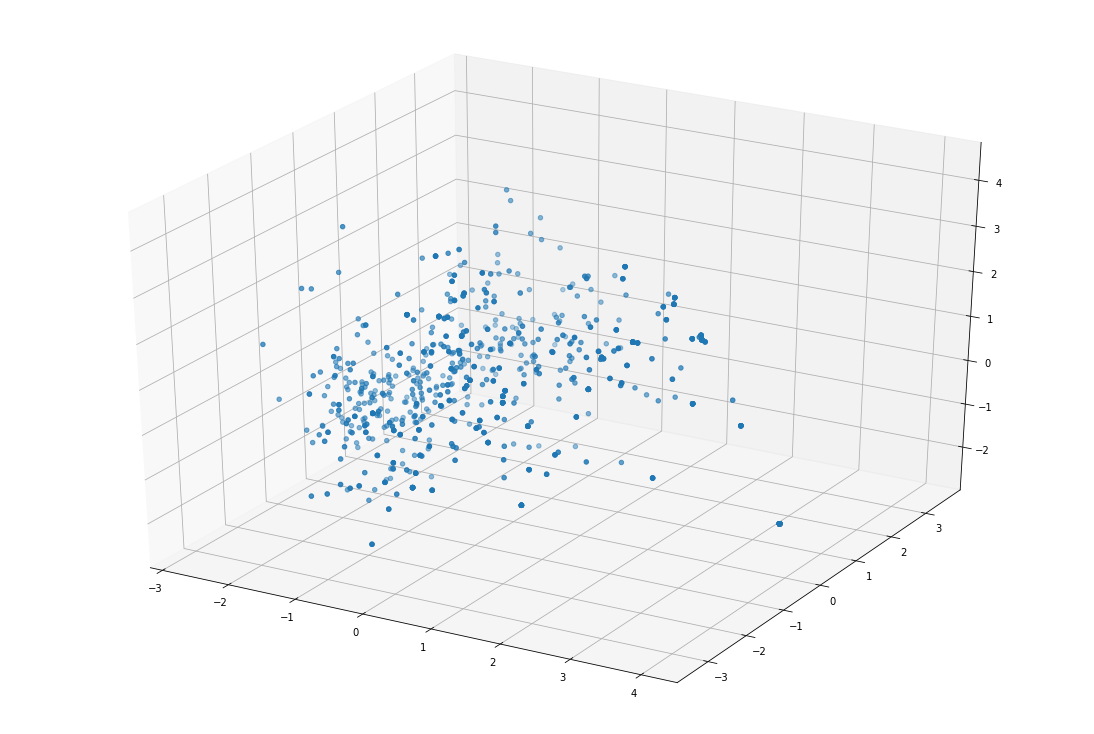

In [4]:
plt.rcParams['figure.figsize'] = (15, 10)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_projected[:, 0], X_projected[:, 1], X_projected[:, 2])

Clustering into 10 clusters

In [7]:
true_k = 10
model = KMeans(n_clusters=true_k)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [8]:
vocabulary = list({w for w in nlp.vocab if w.has_vector and w.is_lower})

centroids = []
cosine = lambda v1, v2: np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
for i, centroid in tqdm(enumerate(model.cluster_centers_)):
    vocabulary.sort(key=lambda w: cosine(w.vector, centroid), reverse=True)
    centroids.append(vocabulary[0])
    
    print("\nCluster " + str(i))
    
    for word in vocabulary[:10]:
        print(f"\t {word.text: <{10}} \t {cosine(word.vector, centroid)}")

0it [00:00, ?it/s]


Cluster 0
	 north      	 0.9675514101982117
	 west       	 0.9668622016906738
	 south      	 0.9607080221176147
	 east       	 0.9575493335723877
	 northwest  	 0.8444217443466187
	 southeast  	 0.8390207290649414
	 northeast  	 0.8379718065261841
	 southwest  	 0.822601318359375
	 northern   	 0.7669702172279358
	 southern   	 0.7578116655349731


1it [00:06,  6.14s/it]


Cluster 1
	 city       	 0.9918897151947021
	 town       	 0.8189122080802917
	 cities     	 0.7716920375823975
	 downtown   	 0.7125087380409241
	 towns      	 0.6935247182846069
	 metropolis 	 0.6822603940963745
	 district   	 0.6802780032157898
	 streets    	 0.6652016043663025
	 metropolitan 	 0.654441773891449
	 suburb     	 0.644318699836731


2it [00:12,  6.21s/it]


Cluster 2
	 one        	 0.7582602500915527
	 where      	 0.75773686170578
	 there      	 0.7535089254379272
	 place      	 0.742250919342041
	 that       	 0.7378548383712769
	 well       	 0.7366309762001038
	 same       	 0.7315817475318909
	 way        	 0.7302769422531128
	 when       	 0.7254212498664856
	 which      	 0.7237482070922852


3it [00:19,  6.41s/it]


Cluster 3
	 government 	 0.7374894618988037
	 capital    	 0.7135130763053894
	 country    	 0.7033669352531433
	 economic   	 0.6872557997703552
	 political  	 0.6859174966812134
	 nation     	 0.6817740797996521
	 citizens   	 0.6719663739204407
	 civil      	 0.6699911952018738
	 society    	 0.6615355014801025
	 city       	 0.6582735776901245


4it [00:25,  6.23s/it]


Cluster 4
	 powiat     	 0.8799590468406677
	 voivodeship 	 0.8170011043548584
	 voivodship 	 0.6436648964881897
	 gmina      	 0.6283050775527954
	 sub-prefecture 	 0.4935481548309326
	 okrug      	 0.4817933738231659
	 préfecture 	 0.47521328926086426
	 voivodeships 	 0.4573071300983429
	 département 	 0.45084628462791443
	 raion      	 0.44953998923301697


5it [00:32,  6.59s/it]


Cluster 5
	 football   	 0.8454858660697937
	 soccer     	 0.8402291536331177
	 club       	 0.8043330907821655
	 sports     	 0.7630301117897034
	 league     	 0.7592044472694397
	 basketball 	 0.759108304977417
	 rugby      	 0.7531476020812988
	 sport      	 0.7420743107795715
	 hockey     	 0.7386873364448547
	 volleyball 	 0.7376388311386108


6it [00:38,  6.34s/it]


Cluster 6
	 area       	 0.8151438236236572
	 region     	 0.8060584664344788
	 areas      	 0.7642800807952881
	 regions    	 0.7485967874526978
	 population 	 0.7354426383972168
	 boundary   	 0.7152004837989807
	 vicinity   	 0.6699795722961426
	 northern   	 0.6627153754234314
	 surrounding 	 0.6608545184135437
	 geographical 	 0.6599677801132202


7it [00:44,  6.22s/it]


Cluster 7
	 centre     	 0.9548123478889465
	 centres    	 0.7281277775764465
	 railway    	 0.6691920757293701
	 situated   	 0.6347851157188416
	 center     	 0.6165837049484253
	 tram       	 0.6091797947883606
	 motorway   	 0.5929069519042969
	 outskirts  	 0.5880892276763916
	 central    	 0.5853435397148132
	 kilometres 	 0.5779902935028076


8it [00:49,  6.04s/it]


Cluster 8
	 lake       	 0.8956688642501831
	 river      	 0.8755216598510742
	 lakes      	 0.799616277217865
	 rivers     	 0.7509194016456604
	 creek      	 0.746238112449646
	 valley     	 0.719631552696228
	 mountain   	 0.7058862447738647
	 pond       	 0.7022004127502441
	 shore      	 0.6919397711753845
	 park       	 0.691250741481781


9it [00:55,  5.93s/it]


Cluster 9
	 university 	 0.8704047203063965
	 student    	 0.835879385471344
	 education  	 0.7946710586547852
	 college    	 0.7913951277732849
	 graduate   	 0.7651934027671814
	 school     	 0.761526882648468
	 academic   	 0.7528790831565857
	 students   	 0.7474098801612854
	 institution 	 0.746220052242279
	 faculty    	 0.7431285977363586


10it [01:01,  5.91s/it]


In [9]:
df_projected = pd.DataFrame(X_projected)
df_projected['Cluster'] = model.labels_
df_projected.head()

,0,1,2,Cluster
0,-1.475056,-0.136470,1.352193,2
1,-1.475060,-0.136461,1.352207,2
2,4.016041,-0.233163,-1.629217,1
3,2.404156,0.585229,1.656526,0
4,0.942238,-1.870510,0.984099,6


Clustered words, for each cluster, the word closest to its centroid has been visualized

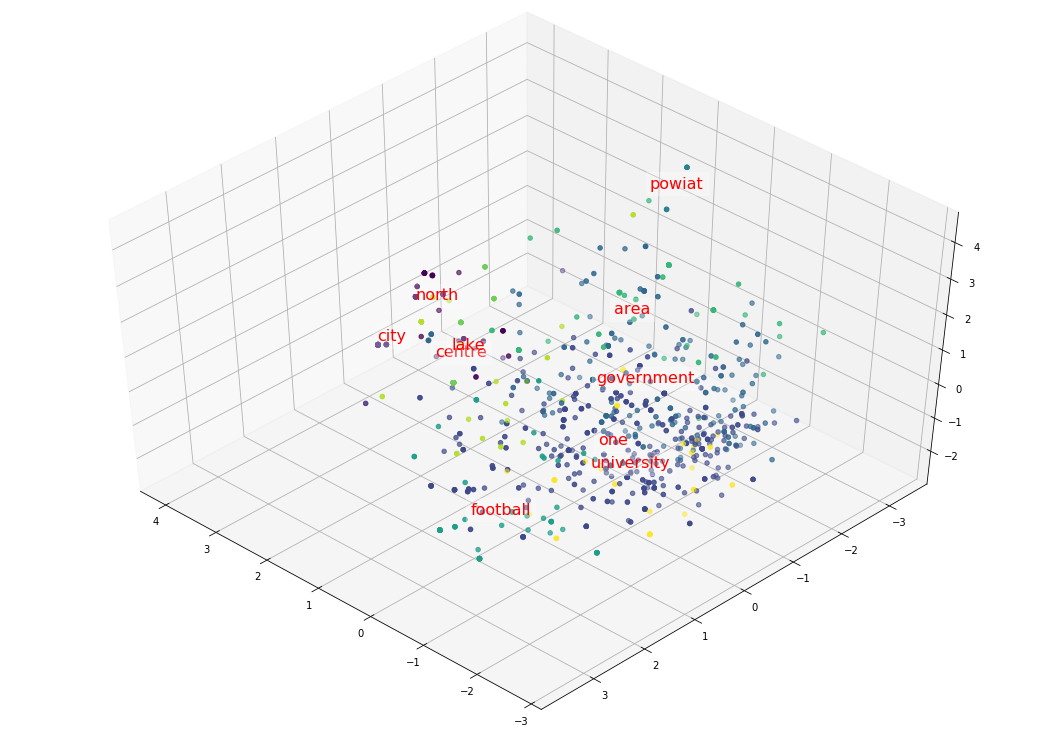

In [10]:
cluster_centers_projected = pca.transform(model.cluster_centers_)

fig = plt.figure(1, figsize=(15, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

for i in range(true_k):
    ax.text3D(cluster_centers_projected[i][0],
              cluster_centers_projected[i][1],
              cluster_centers_projected[i][2], centroids[i].text,
              horizontalalignment='center',
              color='red',
              size=16,
              bbox=dict(alpha=.25, edgecolor='w', facecolor='w'))

ax.scatter(df_projected[0], df_projected[1], df_projected[2], c=df_projected['Cluster'])